# Branchwater output comparison
Branchwater x 14 spp that were in 99% of the pig gut metagenomes
Seem to be core spp. How predictive are they together or in combination that something is a pig, or pig related?

Plots that show this:
- Sankeys
- Bar chart
- percentual stacked bar chart

Have:
- Presence absence matrix with sample,species, 0/1
- df with for each sample what the host is


### Need to update and do BW with other spp

In [55]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px # Import plotly express
import matplotlib.pyplot as plt

In [56]:
# use containment tresholds
df = pd.read_csv('../data/251030_bw_merge.01.csv')
df = df[df['assay_type'] == 'WGS']

In [38]:
# count num times a metaG has a spp
# how many times is a metaG in this df (1-14)
value_counts = df['acc'].value_counts().reset_index()
value_counts.columns = ['acc', 'metag_count']

# Drop dups, merge
df = pd.merge(value_counts, df[['acc', 'organism']], on='acc', how='left')
df = df.drop_duplicates()

In [10]:
# df = pd.read_csv('../data/251001_presence_absence.branchw.csv')
# df2 = pd.read_csv('../data/251001_merged.branchwater.csv')

# # FILTER
# df['metag_count'] = df.iloc[:, 1:].sum(axis=1)
# df = df[df['metag_count'] != 0]
# df = df.merge(df2, on='acc', how='left')
# df = df[df['assay_type'] == 'WGS']
# df = df[['metag_count', 'acc', 'organism']]
# df = df[df['organism'].str.contains('metagenome', case=False, na=False)]

# df['organism'].value_counts()

In [41]:
# OPEN MANUAL CURATION
dfm =  pd.read_csv('../data/251002_samples_over11.csv')
dfm = dfm[["acc", "organism"]]

# Merge with df2, keeping all rows from df2
merged = df.merge(dfm, on="acc", how="left", suffixes=("", "_new"))

# Replace org in df2 with org from df1 where available
merged["organism"] = merged["organism_new"].combine_first(merged["organism"])

# Drop the temporary column
merged_mancur = merged.drop(columns="organism_new")


In [42]:
#df.to_csv('../../2025-pig-binning-paper/250830-branchwater/251001_metagenome_assigned.csv')

In [43]:
# SUBSET

df_sub = merged_mancur[['metag_count', 'organism']]
#df_sub = df[['metag_count', 'organism']]
# df_sub = df[df_sub['metag_count'] != 0]
df_pivot = pd.crosstab(df_sub['organism'], df_sub['metag_count']).reset_index()
df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]

In [25]:
# SUM
numeric_cols = df_pivot.select_dtypes(include='number').columns.tolist()
df_grouped = df_pivot.groupby('broad_cat')[numeric_cols].sum().reset_index()
species_cols = [str(i) for i in range(1, 15)]

In [26]:
# make cumulative df for the sankey diagram
df_cumulative = df_grouped.copy()

In [27]:
for i in range(13, 0, -1):
    # Each column's new value is its old value plus the value of the column to its right
    df_cumulative[str(i)] = df_cumulative[str(i)] + df_cumulative[str(i+1)]

In [34]:
# sankey colors
unique_biomes = df_grouped['broad_cat'].unique()
palette = px.colors.qualitative.Plotly
biome_colors = {biome: palette[i % len(palette)] for i, biome in enumerate(unique_biomes)}

In [35]:
# CREATE SANKEY LAYOUT (ALL NUMBERS, 1-14)
links_data = []
for index, row in df_grouped.iterrows():
    biome = row['broad_cat']
    biome_color = biome_colors[biome]
    start_value =  df_cumulative.loc[index, species_cols].max()  # total across all steps for this biome
    if start_value > 0:
        links_data.append({
            'source': biome,
            'target': '1',
            'value': start_value,
            'color': biome_color
        })

    for i in range(1, 15):
        source = f'{i}'
        if i < 14:
            cont = df_cumulative.loc[index, str(i + 1)]
            if cont > 0:
                links_data.append({'source': source, 'target': f'{i + 1}', 'value': cont, 'color': biome_color})
            drop = row[str(i)]
            if drop > 0:
                links_data.append({'source': source, 'target': f'{i}_drop', 'value': drop, 'color': biome_color})


In [36]:
# use only certain categories 
selected_cols = ['1', '2', '3', '6', '9', '11']
links_data = []
for index, row in df_cumulative.iterrows():
    biome = row['broad_cat']
    biome_color = biome_colors[biome]
    start_bin = selected_cols[0]
    start_value = row[start_bin]
    if start_value > 0:
        links_data.append({
            'source': biome,
            'target': start_bin,
            'value': start_value,
            'color': biome_color
        })
    previous_bin = start_bin
    for col in selected_cols[1:]:
        bin_value = row[col]
        if bin_value > 0:
            links_data.append({
                'source': previous_bin,
                'target': col,
                'value': bin_value,
                'color': biome_color
            })
        previous_bin = col


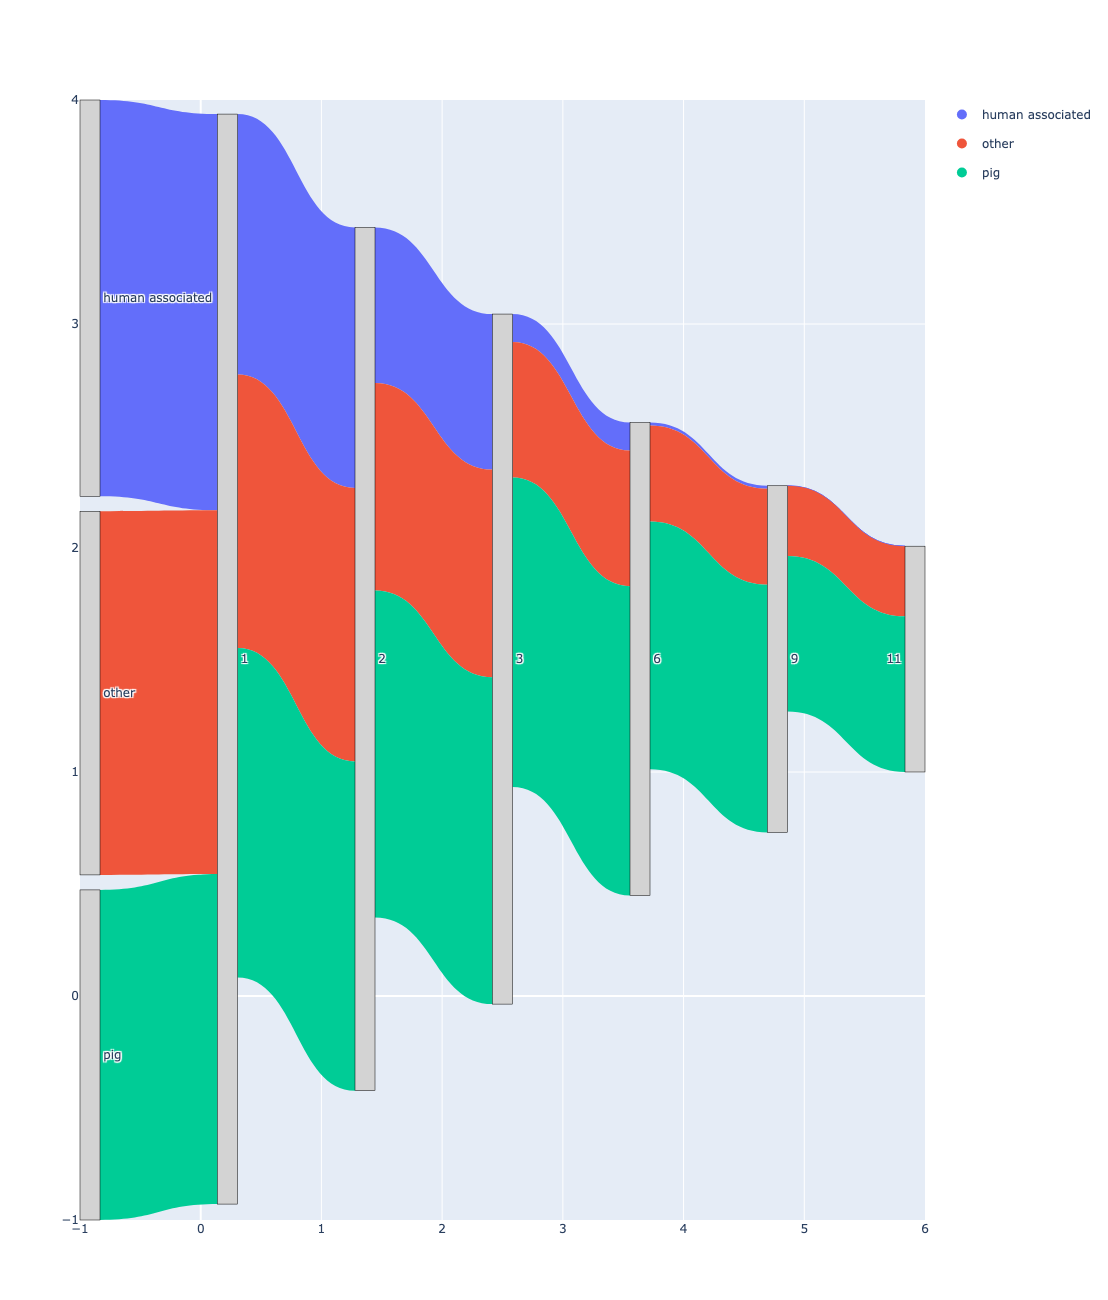

In [37]:
df_sankey = pd.DataFrame(links_data)

# 4. Create the Sankey Diagram with Colored Links
# Get unique labels from the source and target columns
all_labels = sorted(list(pd.unique(df_sankey[['source', 'target']].values.ravel('K'))))

# Map labels to integer indices
label_map = {label: i for i, label in enumerate(all_labels)}
df_sankey['source_id'] = df_sankey['source'].map(label_map)
df_sankey['target_id'] = df_sankey['target'].map(label_map)

fig = go.Figure(data=[go.Sankey(
    arrangement='snap', # Snap nodes to vertical positions
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=all_labels,
      color="lightgray"  # All nodes are a neutral color
    ),
    link=dict(
      source=df_sankey['source_id'],
      target=df_sankey['target_id'],
      value=df_sankey['value'],
      color=df_sankey['color']  # KEY CHANGE: Apply colors to the links
  ))])

for biome, color in biome_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None], # Invisible coordinates
        mode='markers',
        marker=dict(size=10, color=color),
        legendgroup=biome,
        showlegend=True,
        name=biome
    ))
fig.update_layout( 
    font_size=12,
    width=1200,  # Set plot width
    height=1300   # Set plot height
)
fig.show()
fig.write_html("../../2025-pig-binning-paper/250830-branchwater/sankey_diagram.mancur.simple.numbercat.html", include_plotlyjs='cdn')
# fig.write_image("sankey_diagram.svg")







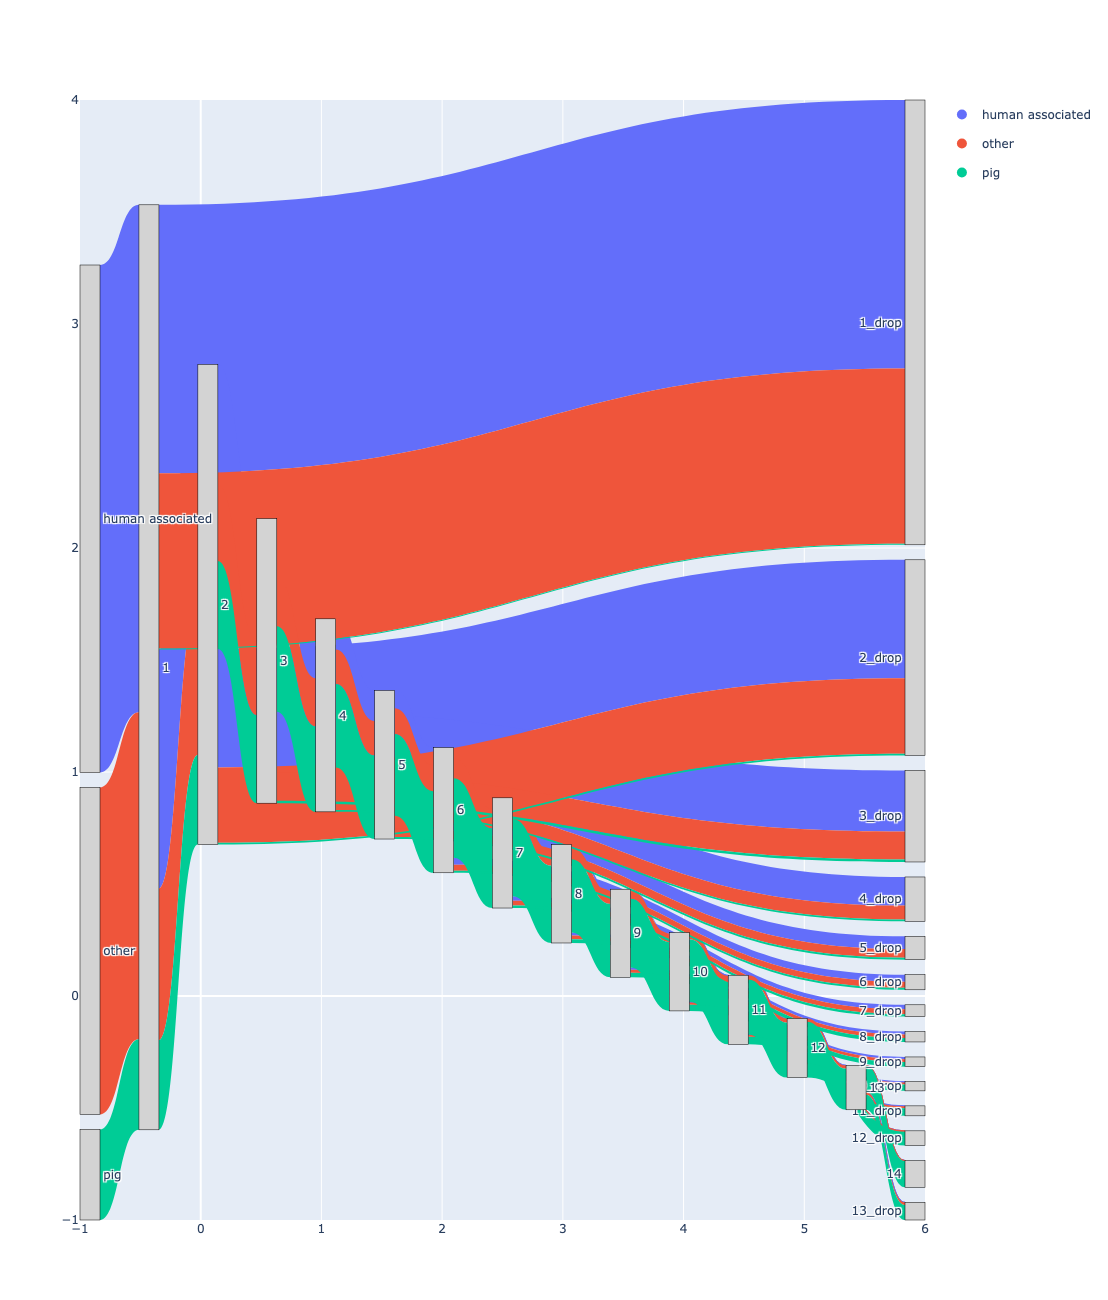

In [244]:
links_data = []

for index, row in df_grouped.iterrows():
    biome = row['broad_cat']
    biome_color = biome_colors[biome]

    start_value =  df_cumulative.loc[index, species_cols].max()  # total across all steps for this biome
    if start_value > 0:
        links_data.append({
            'source': biome,
            'target': '1',
            'value': start_value,
            'color': biome_color
        })

    for i in range(1, 15):
        source = f'{i}'
        if i < 14:
            cont = df_cumulative.loc[index, str(i + 1)]
            if cont > 0:
                links_data.append({'source': source, 'target': f'{i + 1}', 'value': cont, 'color': biome_color})
            drop = row[str(i)]
            if drop > 0:
                links_data.append({'source': source, 'target': f'{i}_drop', 'value': drop, 'color': biome_color})
df_sankey = pd.DataFrame(links_data)

# 4. Create the Sankey Diagram with Colored Links
# Get unique labels from the source and target columns
all_labels = sorted(list(pd.unique(df_sankey[['source', 'target']].values.ravel('K'))))

# Map labels to integer indices
label_map = {label: i for i, label in enumerate(all_labels)}
df_sankey['source_id'] = df_sankey['source'].map(label_map)
df_sankey['target_id'] = df_sankey['target'].map(label_map)

fig = go.Figure(data=[go.Sankey(
    arrangement='snap', # Snap nodes to vertical positions
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=all_labels,
      color="lightgray"  # All nodes are a neutral color
    ),
    link=dict(
      source=df_sankey['source_id'],
      target=df_sankey['target_id'],
      value=df_sankey['value'],
      color=df_sankey['color']  # KEY CHANGE: Apply colors to the links
  ))])

for biome, color in biome_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None], # Invisible coordinates
        mode='markers',
        marker=dict(size=10, color=color),
        legendgroup=biome,
        showlegend=True,
        name=biome
    ))
fig.update_layout( 
    font_size=12,
    width=1200,  # Set plot width
    height=1300   # Set plot height
)
fig.show()
fig.write_html("../../2025-pig-binning-paper/250830-branchwater/sankey_diagram.mancur.simple.html", include_plotlyjs='cdn')
# fig.write_image("sankey_diagram.svg")







In [33]:
# # 3. Build Sankey Links with Color Data
# # We create a separate link for each biome at each step to color them individually.
# links_data = []

# for index, row in df_grouped.iterrows():
#     biome = row['broad_cat']
#     biome_color = biome_colors[biome]

#     for i in range(1, 15):
#         source_node = f'{i}'
        
#         # Add the drop-off link for this biome
#         drop_off_value = row[str(i)]
#         if drop_off_value > 0:
#             links_data.append({
#                 'source': source_node,
#                 'target': f'{i} ',
#                 'value': drop_off_value,
#                 'color': biome_color
#             })
        
#         # Add the continuation link for this biome
#         if i < 14:
#             continuation_value = df_cumulative.loc[index, str(i + 1)]
#             if continuation_value > 0:
#                 links_data.append({
#                     'source': source_node,
#                     'target': f'{i + 1}',
#                     'value': continuation_value,
#                     'color': biome_color
#                 })

# df_sankey = pd.DataFrame(links_data)

# # 4. Create the Sankey Diagram with Colored Links
# # Get unique labels from the source and target columns
# all_labels = sorted(list(pd.unique(df_sankey[['source', 'target']].values.ravel('K'))))

# # Map labels to integer indices
# label_map = {label: i for i, label in enumerate(all_labels)}
# df_sankey['source_id'] = df_sankey['source'].map(label_map)
# df_sankey['target_id'] = df_sankey['target'].map(label_map)

# fig = go.Figure(data=[go.Sankey(
#     arrangement='snap', # Snap nodes to vertical positions
#     node=dict(
#       pad=15,
#       thickness=20,
#       line=dict(color="black", width=0.5),
#       label=all_labels,
#       color="lightgray"  # All nodes are a neutral color
#     ),
#     link=dict(
#       source=df_sankey['source_id'],
#       target=df_sankey['target_id'],
#       value=df_sankey['value'],
#       color=df_sankey['color']  # KEY CHANGE: Apply colors to the links
#   ))])

# for biome, color in biome_colors.items():
#     fig.add_trace(go.Scatter(
#         x=[None], y=[None], # Invisible coordinates
#         mode='markers',
#         marker=dict(size=10, color=color),
#         legendgroup=biome,
#         showlegend=True,
#         name=biome
#     ))
# fig.update_layout( 
#     font_size=12,
#     width=1000,  # Set plot width
#     height=1200   # Set plot height
# )
# fig.show()

In [63]:
df_grouped

,broad_cat,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,human associated,23657,9145,3978,1681,713,370,201,93,49,10,1,1,0,0
1,other,15696,5744,1981,929,575,432,301,243,128,137,134,83,21,6
2,pig,140,202,235,217,296,380,490,661,861,1024,1198,1057,645,160


In [47]:
#df_pivot.to_csv('test.csv')

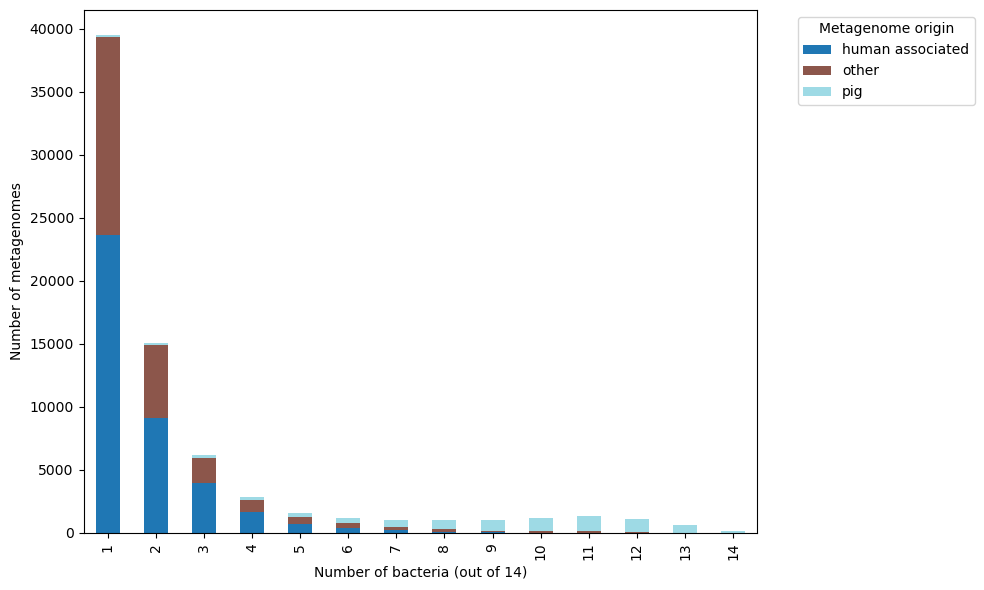

In [64]:
# make chart with absolute numbers
numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

df_abs = df_grouped.set_index('broad_cat')[numeric_cols]
ax = df_abs.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
ax.set_ylabel('Number of metagenomes')
ax.set_xlabel('Number of bacteria (out of 14)')

plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yscale('log')
plt.tight_layout()
#plt.show()
#plt.savefig('../plots/251001_absolute_metag.branchwater.png')


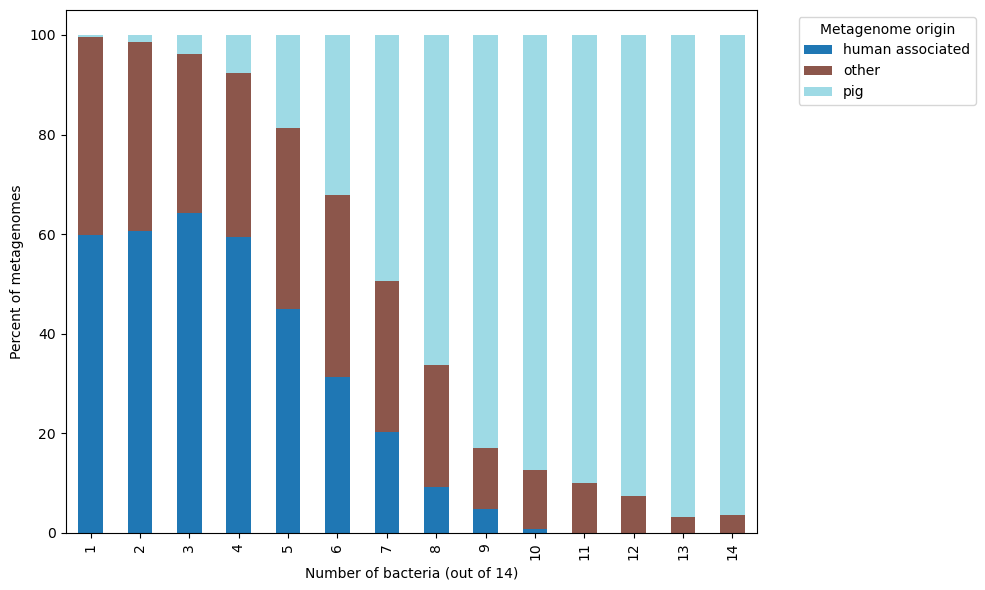

In [53]:

# Automatically select numeric columns
numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

# Normalize each column to sum to 100%
df_norm = df_grouped.set_index('broad_cat')[numeric_cols].div(df_grouped[numeric_cols].sum(axis=0), axis=1) * 100

# Plot stacked bar chart
ax = df_norm.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
ax.set_ylabel('Percent of metagenomes')
ax.set_xlabel('Number of bacteria (out of 14)')
plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('../plots/251001_percent_metag.branchwater.png')


## Manually checked the SRAs for over 11
- Are they pig adjecent?
- Mislabeled?

Most are. Id like to only plot bars 12,13,14 cause those are the ones I man curated

In [342]:
df = pd.read_csv('../../2025-pig-binning-paper/250830-branchwater/251002_samples_over11.csv')

In [343]:
df['metag_count'].value_counts()

metag_count
14    2165
13    1439
12    1193
Name: count, dtype: int64

In [353]:

# Keep only the columns we care about
df_sub = df[['metag_count', 'organism']]

# Drop rows where metag_count is 0, if needed
df_sub = df_sub[df_sub['metag_count'] != 0]

# Use pd.crosstab to get counts
df_pivot = pd.crosstab(df_sub['organism'], df_sub['metag_count']).reset_index()

# Optional: rename columns nicely
df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]

In [354]:
df_pivot

,organism,12,13,14
0,air metagenome,1,0,2
1,bioreactor - pig manure,2,8,23
2,bioreactor metagenome,0,0,1
3,bovine gut metagenome,48,31,20
4,chicken gut,1,0,0
5,human gut,3,5,1
6,lichen metagenome,0,0,1
7,macaque metagenome,4,6,1
8,manure metagenome,3,1,1
9,other_mammal,0,0,1


In [355]:
category_map = {
    'human': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa', 'swine'],
    'other_mammal': ['cow', 'bovine', 'bos','musculus', 'mouse', 'rat','canine', 'feline'],
    'poultry':['chicken', 'poultry', 'gallus'],
    'soil':['sediment', 'soil', 'sludge', 'wetland', 'bog'],
    'bioreactor': ['bioreactor'],
    'water':['water', 'marine']}


# Function to assign category based on keywords
def get_broad_cat(organism):
    for cat, keywords in category_map.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match


df_pivot['broad_cat'] = df_pivot['organism'].apply(get_broad_cat)
df_pivot.loc[df_pivot['organism'].str.lower() == 'metagenome', 'broad_cat'] = 'metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'gut metagenome', 'broad_cat'] = 'gut metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'feces metagenome', 'broad_cat'] = 'feces metagenome'


In [364]:
df_pivot.loc[df_pivot['organism'].str.lower() == 'pig gut metagenome', 'broad_cat'] = 'pig gut metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'pig or chicken feces', 'broad_cat'] = 'pig or chicken feces'
df_pivot.loc[df_pivot['organism'].str.lower() == 'unknown - unlabeled', 'broad_cat'] = 'unknown - unlabeled'


In [365]:
df_pivot

,organism,12,13,14,broad_cat
0,air metagenome,1,0,2,other
1,bioreactor - pig manure,2,8,23,pig
2,bioreactor metagenome,0,0,1,bioreactor
3,bovine gut metagenome,48,31,20,other_mammal
4,chicken gut,1,0,0,poultry
5,human gut,3,5,1,human
6,lichen metagenome,0,0,1,other
7,macaque metagenome,4,6,1,other
8,manure metagenome,3,1,1,other
9,other_mammal,0,0,1,other


In [366]:
# Automatically select all numeric columns
numeric_cols = df_pivot.select_dtypes(include='number').columns.tolist()

# Group by broad_cat and sum numeric columns
df_grouped = df_pivot.groupby('broad_cat')[numeric_cols].sum().reset_index()

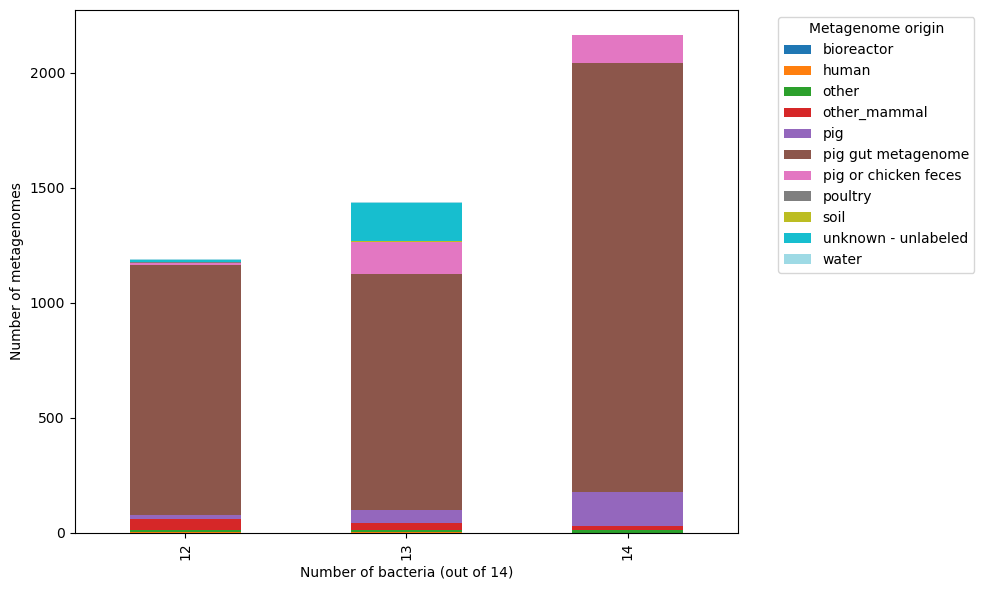

In [367]:
# make chart with absolute numbers
numeric_cols = df_grouped.select_dtypes(include='number').columns.tolist()

df_abs = df_grouped.set_index('broad_cat')[numeric_cols]
ax = df_abs.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
ax.set_ylabel('Number of metagenomes')
ax.set_xlabel('Number of bacteria (out of 14)')

plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.show()
plt.savefig('../plots/251001_absolute_metag.over11.mancur.png')


## Functions

In [58]:
# MAP CATEGORIES
category_map = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa'],
    'other_mammal': ['cow', 'bovine', 'bos','musculus', 'mouse', 'rat','canine', 'feline', 'sheep'],
    'poultry':['chicken', 'poultry', 'gallus', 'bird']}


# Function to assign category based on keywords
def get_broad_cat(organism):
    for cat, keywords in category_map.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match


df_pivot['broad_cat'] = df_pivot['organism'].apply(get_broad_cat)
df_pivot.loc[df_pivot['organism'].str.lower() == 'metagenome', 'broad_cat'] = 'metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'gut metagenome', 'broad_cat'] = 'gut metagenome'
df_pivot.loc[df_pivot['organism'].str.lower() == 'feces metagenome', 'broad_cat'] = 'feces metagenome'

In [59]:
# SAME BUT SIMPLE
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  # default if no keywords match


df_pivot['broad_cat'] = df_pivot['organism'].apply(get_broad_cat_simple)